**Variational Autoencoder (VAE)**

**Question 1**

The code has been taken from https://keras.io/examples/generative/vae/ and modified according to the assignment. The key to this assignment was to keep the input dimension of encoder and output dimensions of the decoder same (None,28,28,1).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

**Create Sampling Layer**

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Encoder**

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

**Decoder**

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x) ## To match input and output the stride should be 1
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 6272)              18816     
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 32)        1846

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist = np.concatenate([x_train, x_test], axis=0)
fmnist= np.expand_dims(fmnist, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fmnist, epochs=30, batch_size=128)

4422102/4422102 [==============================] - 1s 0us/step
Epoch 1/30
547/547 [==============================] - 18s 7ms/step - loss: 377.7387 - reconstruction_loss: 322.5808 - kl_loss: 8.2280
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 281.6458 - reconstruction_loss: 270.5939 - kl_loss: 8.4252
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - loss: 273.6774 - reconstruction_loss: 265.1540 - kl_loss: 7.8888
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - loss: 270.7011 - reconstruction_loss: 262.3683 - kl_loss: 7.7310
Epoch 5/30
547/547 [==============================] - 4s 6ms/step - loss: 268.5806 - reconstruction_loss: 260.7916 - kl_loss: 7.7119
Epoch 6/30
547/547 [==============================] - 4s 6ms/step - loss: 266.2799 - reconstruction_loss: 259.0708 - kl_loss: 7.6634
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - loss: 266.1407 - reconstruction_loss: 258.0970 - kl_loss: 7.6248
Epoch

1/1 [==============================] - 0s 18ms/step


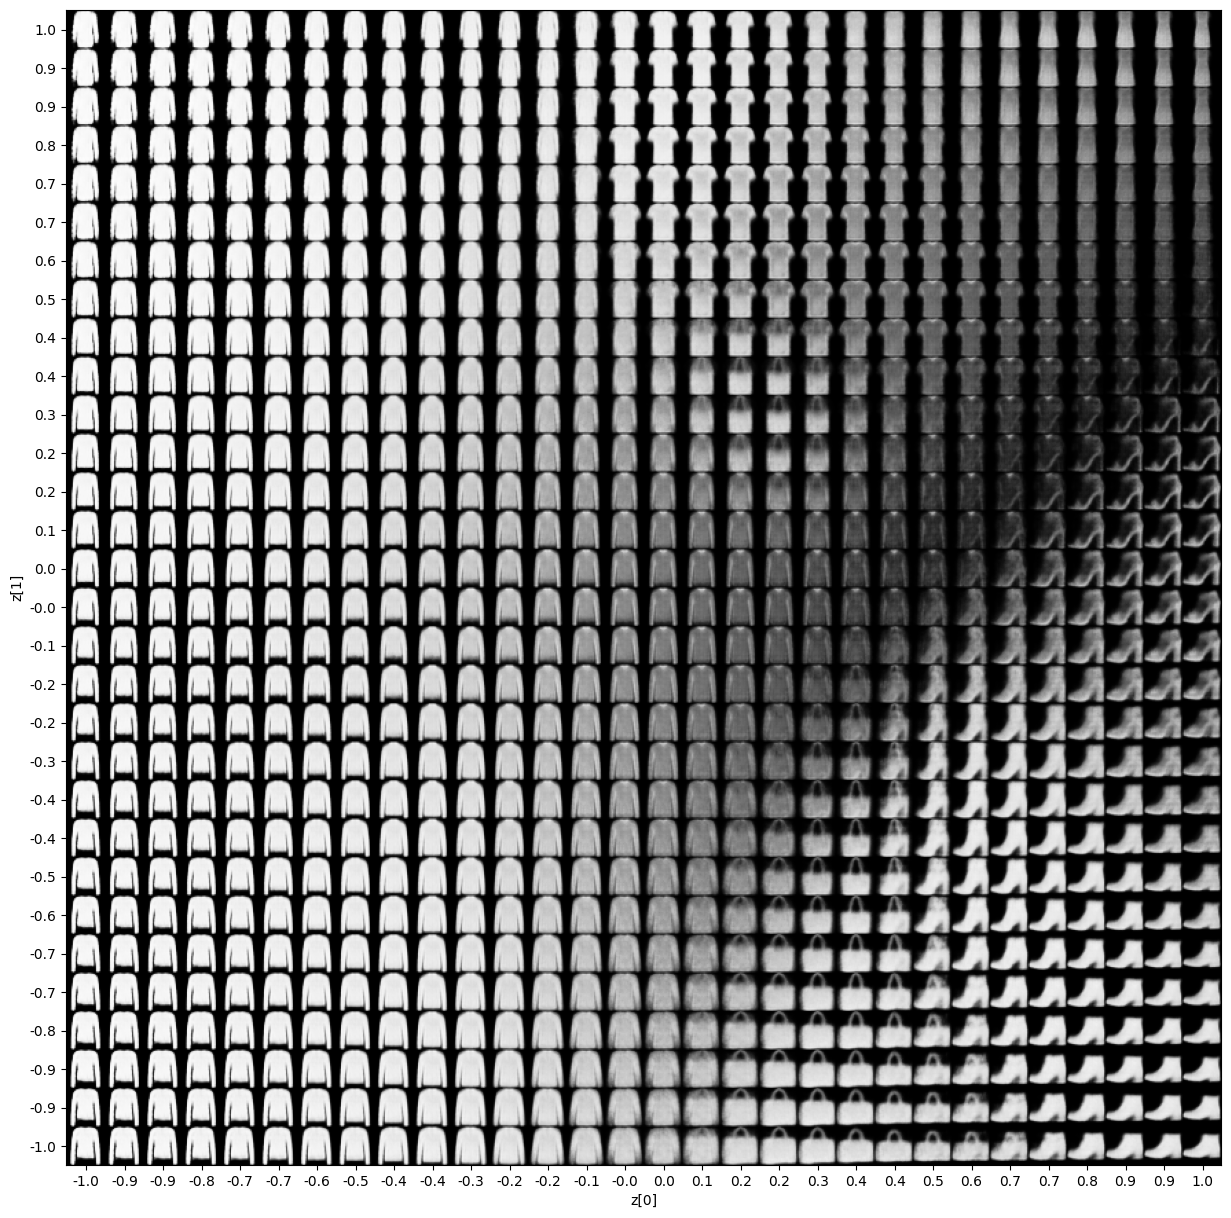

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

1875/1875 [==============================] - 3s 2ms/step


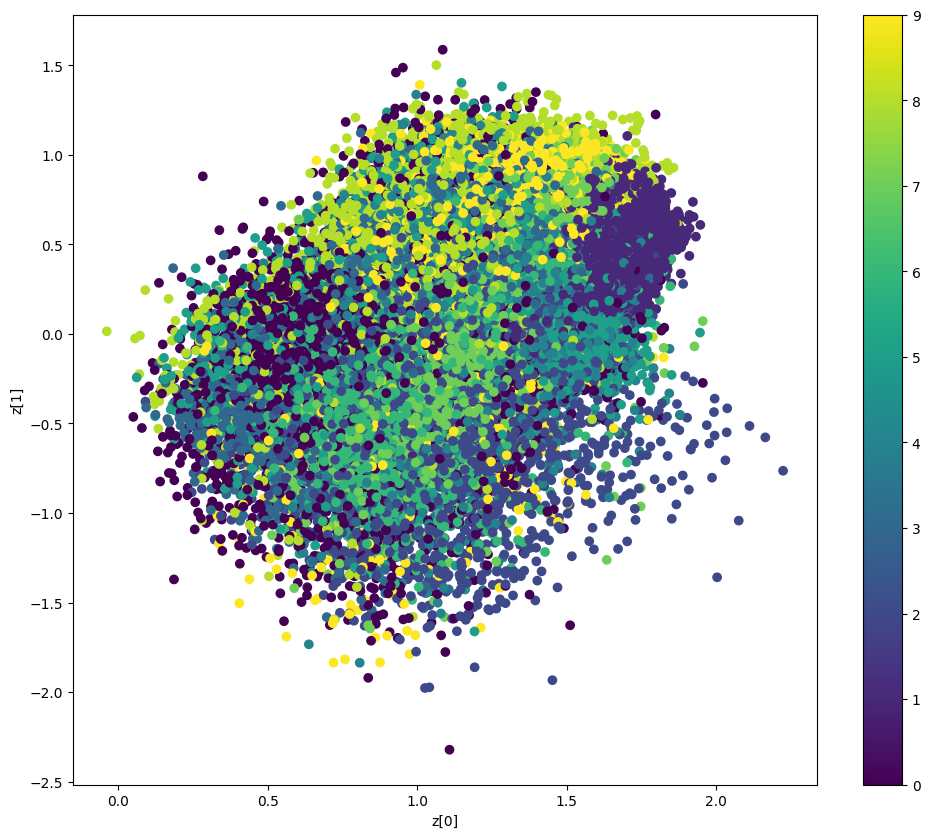

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

**Question2: IMDB Review Dataset - Sentiment Analysis**

These code snippets are inspired from my NLP projects.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from wordcloud import WordCloud



In [ ]:
# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#!unzip /content/drive/MyDrive/DeepLearning/HW/HW3/IMDB\ Dataset.csv.zip -d /content/drive/MyDrive/DeepLearning/HW/HW3/

Archive:  /content/drive/MyDrive/DeepLearning/HW/HW3/IMDB Dataset.csv.zip
  inflating: /content/drive/MyDrive/DeepLearning/HW/HW3/IMDB Dataset.csv  


In [ ]:
# Load the IMDB dataset
df = pd.read_csv('/content/drive/MyDrive/DeepLearning/HW/HW3/IMDB Dataset.csv')  # Replace with your dataset path


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
import re

In [ ]:
df['review'][742]

'Mario Lewis of the Competitive Enterprise Institute has written a definitive 120-page point-by-point, line-by-line refutation of this mendacious film, which should be titled A CONVENIENT LIE. The website address where his debunking report, which is titled "A SKEPTIC\'S GUIDE TO AN INCONVENIENT TRUTH" can be found at is :www.cei.org. A shorter 10-page version can be found at: www.cei.org/pdf/5539.pdf Once you read those demolitions, you\'ll realize that alleged "global warming" is no more real or dangerous than the Y2K scare of 1999, which Gore also endorsed, as he did the pseudo-scientific film THE DAY AFTER TOMORROW, which was based on a book written by alleged UFO abductee Whitley Strieber. As James "The Amazing" Randi does to psychics, and Philip Klass does to UFOs, and Gerald Posner does to JFK conspir-idiocy theories, so does Mario Lewis does to Al Gore\'s movie and the whole "global warming" scam.'

In [ ]:
import time
import string
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#### Removing HTML tags,punctuations,special characters etc using regular expressions.
TAG_RE = re.compile(r'<[^>]+>') # match anything in the tag <...>

def remove_tags(text):
    #print(text)
    return TAG_RE.sub('', text) # replace that tag with a null string

def process_text(sen):
    #print(sen)
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # look for any character except a toz or A to Z and replace with space

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Look for one or more space with any a-z or a-Z letter followed by multiple space and replace with a space
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence) # finally check for continuous space and replace them with a single space

    return sentence

In [ ]:
# clean text data
start = time.time()
for row in df.itertuples():
    article = process_text(str(df.loc[row.Index,'review']))
    df.loc[row.Index,'review'] = article
stop = time.time()
print(f'Cleaning took: {round((stop-start)/60, 3)} minutes')

Cleaning took: 0.283 minutes


In [ ]:
df['review'][742]

'Mario Lewis of the Competitive Enterprise Institute has written definitive page point by point line by line refutation of this mendacious film which should be titled CONVENIENT LIE The website address where his debunking report which is titled SKEPTIC GUIDE TO AN INCONVENIENT TRUTH can be found at is www cei org shorter page version can be found at www cei org pdf pdf Once you read those demolitions you ll realize that alleged global warming is no more real or dangerous than the scare of which Gore also endorsed as he did the pseudo scientific film THE DAY AFTER TOMORROW which was based on book written by alleged UFO abductee Whitley Strieber As James The Amazing Randi does to psychics and Philip Klass does to UFOs and Gerald Posner does to JFK conspir idiocy theories so does Mario Lewis does to Al Gore movie and the whole global warming scam '

In [ ]:
def remove_urls_emails(text):
    # Remove URLs that start with 'http' or 'www' or emails
    text = re.sub(r'\bwww\b', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    return text

# Apply the function to the 'sentiment' column
df['review'] = df['review'].apply(remove_urls_emails)


In [ ]:
df['review'][742]

'Mario Lewis of the Competitive Enterprise Institute has written definitive page point by point line by line refutation of this mendacious film which should be titled CONVENIENT LIE The website address where his debunking report which is titled SKEPTIC GUIDE TO AN INCONVENIENT TRUTH can be found at is  cei org shorter page version can be found at  cei org pdf pdf Once you read those demolitions you ll realize that alleged global warming is no more real or dangerous than the scare of which Gore also endorsed as he did the pseudo scientific film THE DAY AFTER TOMORROW which was based on book written by alleged UFO abductee Whitley Strieber As James The Amazing Randi does to psychics and Philip Klass does to UFOs and Gerald Posner does to JFK conspir idiocy theories so does Mario Lewis does to Al Gore movie and the whole global warming scam '

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [ ]:
# These excluding words are important for capturing the negactive sentiments.
# Therefore, should not be taken out of the stopword list.
def clean_review(text):
    excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren',
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove stop words
    stop = stopwords.words('english')
    #print("stop english",stop)
    # New stop word list
    stop_words = [word for word in stop if word not in excluding]
    #print("stop words",stop_words)

    text = [x for x in text if x not in stop_words]
    #print("text words",text)

    text = [word.strip(string.punctuation) for word in text]

    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
start = time.time()
df["clean_review"] = df["review"].apply(lambda x: clean_review(x))
stop = time.time()
print(f'Cleaning took: {round((stop-start)/60, 3)} minutes')


Cleaning took: 6.146 minutes


In [ ]:
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch oz episode hook rig...
1,A wonderful little production The filming tech...,positive,wonderful little production film technique una...
2,I thought this was wonderful way to spend time...,positive,think wonderful way spend time hot summer week...
3,Basically there family where little boy Jake t...,negative,basically family little boy jake think zombie ...
4,Petter Mattei Love in the Time of Money is vis...,positive,petter mattei love time money visually stunnin...


In [ ]:
df[df["clean_review"]==""]["review"].value_counts() # No empty rows of clean_review

Series([], Name: review, dtype: int64)

In [ ]:
df.isnull().sum()

review          0
sentiment       0
clean_review    0
dtype: int64

In [ ]:
df.tail()

,review,sentiment,clean_review
49995,I thought this movie did down right good job I...,positive,think movie right good job wasn creative origi...
49996,Bad plot bad dialogue bad acting idiotic direc...,negative,bad plot bad dialogue bad act idiotic direct a...
49997,I am Catholic taught in parochial elementary s...,negative,catholic teach parochial elementary school nun...
49998,I going to have to disagree with the previous ...,negative,go disagree previous comment side maltin one s...
49999,No one expects the Star Trek movies to be high...,negative,one expect star trek movie high art fan expect...


In [ ]:
df['target'] = np.where(df['sentiment']=='positive',1,0)
df.head(-5)

,review,sentiment,clean_review,target
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch oz episode hook rig...,1
1,A wonderful little production The filming tech...,positive,wonderful little production film technique una...,1
2,I thought this was wonderful way to spend time...,positive,think wonderful way spend time hot summer week...,1
3,Basically there family where little boy Jake t...,negative,basically family little boy jake think zombie ...,0
4,Petter Mattei Love in the Time of Money is vis...,positive,petter mattei love time money visually stunnin...,1
...,...,...,...,...
49990,Lame lame lame minute cringe fest that minutes...,negative,lame lame lame minute cringe fest minute long ...,0
49991,Les Visiteurs the first movie about the mediev...,negative,le visiteurs first movie medieval time travele...,0
49992,John Garfield plays Marine who is blinded by g...,positive,john garfield play marine blind grenade fight ...,1
49993,Robert Colomb has two full time jobs He known ...,negative,robert colomb two full time job know throughou...,0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
HOME = '/content/drive/MyDrive/DeepLearning/HW/HW3'

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir(HOME)
os.getcwd()

'/content/drive/MyDrive/DeepLearning/HW/HW3'

In [ ]:
df.to_csv(f'{HOME}/cleanedfile.csv', index=False)

**Model Training**

As per Literature, Gaussian Naive Bayes works better when the output class is continuous in nature and Multinomial Naive Bayes works better with discrete output multiple classes and BernoulliNB works with binary classification. Here, I am using Gaussian and Bernoulli Naive Bayes along with other embedding methods for evaluation. I chose Bernoulli NB too just for comparison as this data is a binary classification problem.

In [ ]:
df = pd.read_csv(f'{HOME}/cleanedfile.csv')
df.head()

,review,sentiment,clean_review,target
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch oz episode hook rig...,1
1,A wonderful little production The filming tech...,positive,wonderful little production film technique una...,1
2,I thought this was wonderful way to spend time...,positive,think wonderful way spend time hot summer week...,1
3,Basically there family where little boy Jake t...,negative,basically family little boy jake think zombie ...,0
4,Petter Mattei Love in the Time of Money is vis...,positive,petter mattei love time money visually stunnin...,1


In [ ]:
import gensim.downloader as api
import nltk
nltk.download('punkt')
from gensim.utils import simple_preprocess


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TF-IDF + Gaussian**

**TF-IDF + BernoulliNB**

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['target'], test_size=0.2, random_state=42)
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

In [ ]:
# TF-IDF + GaussianNB
tfidf_vectorizer = TfidfVectorizer(max_features=100000,ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
gnb_tfidf = GaussianNB()
gnb_tfidf.fit(X_train_tfidf.toarray(), y_train)
predictionsGNB_tfidf = gnb_tfidf.predict(X_test_tfidf.toarray())

In [ ]:
gbb_tfidf = BernoulliNB()
gbb_tfidf.fit(X_train_tfidf.toarray(), y_train)
predictionsBNB_tfidf = gbb_tfidf.predict(X_test_tfidf.toarray())

**Word2Vec + Gaussian**

**Word2Vec + Bernoulli**

In [ ]:
# Word2Vec (CBoW) + GaussianNB
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def calculate_word2vec_sentence_vector(tokens):
    vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(word2vec_model.vector_size)

In [ ]:
X_train_word2vec = np.array([calculate_word2vec_sentence_vector(word_tokenize(text)) for text in tqdm(X_train)])
X_test_word2vec = np.array([calculate_word2vec_sentence_vector(word_tokenize(text)) for text in tqdm(X_test)])

100%|██████████| 10000/10000 [00:08<00:00, 1154.14it/s]


In [ ]:
gnb_word2vec = GaussianNB()
gnb_word2vec.fit(X_train_word2vec, y_train)
predictionsGNB_word2vec = gnb_word2vec.predict(X_test_word2vec)


In [ ]:
gbb_word2vec = BernoulliNB()
gbb_word2vec.fit(X_train_word2vec, y_train)
predictionsBNB_word2vec = gbb_word2vec.predict(X_test_word2vec)

**GloVe + GaussianNB**

**GloVe + BernoulliNB**

In [ ]:
import gensim.downloader as api

In [ ]:
glove_model_path = "/content/drive/MyDrive/DeepLearning/Project/data/glove.6B.300d.txt"

def load_glove_model(glove_file):
    print("Loading GloVe model...")
    model = {}
    with open(glove_file, encoding="utf-8") as file:
        for line in tqdm(file):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            model[word] = vector
    print(f"Loaded {len(model)} word vectors.")
    return model

In [ ]:
def calculate_glove_sentence_vector(tokens, glove_model):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(len(list(glove_model.values())[0]))


In [ ]:
# Load GloVe model
glove_model = load_glove_model(glove_model_path)

Loading GloVe model...


400000it [00:26, 15244.97it/s]


Loaded 400000 word vectors.


In [ ]:
# Calculate sentence vectors for training and testing data
X_train_glove = np.array([calculate_glove_sentence_vector(word_tokenize(text), glove_model) for text in tqdm(X_train)])
X_test_glove = np.array([calculate_glove_sentence_vector(word_tokenize(text), glove_model) for text in tqdm(X_test)])

100%|██████████| 10000/10000 [00:07<00:00, 1427.53it/s]


In [ ]:
gnb_glove = GaussianNB()
gnb_glove.fit(X_train_glove, y_train)
predictionsGNB_glove = gnb_glove.predict(X_test_glove)

In [ ]:
gbb_glove = BernoulliNB()
gbb_glove.fit(X_train_glove, y_train)
predictionsBNB_glove = gbb_glove.predict(X_test_glove)

**Comparion Between all the Techniques**

In [ ]:
# Performance Comparison
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy ({model_name}): {accuracy:.4f}")

    print(f"Classification Report ({model_name}):\n{classification_report(y_true, y_pred)}")
    return {'Technique': model_name, 'Accuracy': accuracy}

results_df = pd.DataFrame(columns=['Technique', 'Accuracy'])

# Use the function to update results_df
new_row = evaluate_model(y_test, predictionsGNB_tfidf, "TF-IDF + GaussianNB")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

new_row = evaluate_model(y_test, predictionsBNB_tfidf, "TF-IDF + BernoulliNB")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

new_row = evaluate_model(y_test, predictionsGNB_word2vec, "Word2Vec + GaussianNB")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

new_row = evaluate_model(y_test, predictionsBNB_word2vec, "Word2Vec + BernoulliNB")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

new_row = evaluate_model(y_test, predictionsGNB_glove, "GloVe + GaussianNB")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

new_row = evaluate_model(y_test, predictionsBNB_glove, "GloVe + BernoulliNB")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

results_df


Accuracy (TF-IDF + GaussianNB): 0.8108
Classification Report (TF-IDF + GaussianNB):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4961
           1       0.82      0.80      0.81      5039

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Accuracy (TF-IDF + BernoulliNB): 0.8804
Classification Report (TF-IDF + BernoulliNB):
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy (Word2Vec + GaussianNB): 0.7589
Classification Report (Word2Vec + GaussianNB):
              precision    recall  f1-score   support

           0       0.74      0.79

,Technique,Accuracy
0,TF-IDF + GaussianNB,0.8108
1,TF-IDF + BernoulliNB,0.8804
2,Word2Vec + GaussianNB,0.7589
3,Word2Vec + BernoulliNB,0.7439
4,GloVe + GaussianNB,0.7379
5,GloVe + BernoulliNB,0.7311


TF_IDF+BernoulliNB gave the best accuracy followed by TF-IDF+ GaussianNB.These two techniques have the best F1 score as well 88% and 81%. In this data, I have used 0 as Negative Sentiment and 1 as Positive Sentiment. For all of the embeddings TF-IDF + Gaussian, Word2Vec + Gaussian, GloVe + Gaussian, the recall for 0 (Negative sentiment) is higher than the 1(positive sentiment) which tells that these models are able to detect most of the negative samples.

**Question 3: Byte Pair Encoding**

The content is inspired from https://www.geeksforgeeks.org/byte-pair-encoding-bpe-in-nlp/

**Byte-Pair Encoding** (BPE) is used in Natural Language Processing (NLP) to compress or to express a big vocabulary using a limited number of subword units. BPE works on the basis of merging the most common consecutive bytes or characters in a text corpus iteratively until a user defined vocabulary size is achieved. The generated subword units can be utilized to more effectively and compactly represent the source text. This is super useful in understanding and working with large amounts of text, like in translating languages or figuring out if a piece of writing is positive or negative.



**Steps involved in BPE**

**Step 1:**

Start with the vocabulary containing all individual bytes or characters present in the given text corpus.

**Step 2:**

Calculate the frequency of each byte or character in the text corpus.

**Step 3:**

Repeat the following steps until the desired vocabulary size is reached:


*  Find the most frequent pair of consecutive bytes or characters in the text corpus.
*  Merge the identified pair to create a new subword unit. This involves combining the two consecutive bytes or characters into a single unit.
*  Update the frequency counts of all the bytes or characters that contain the merged pair. This ensures accurate frequency tracking after the merge.
*  Add the new subword unit to the vocabulary. This expands the set of building blocks available for representation.

**Step 5:**

Represent the text corpus using the subword units in the updated vocabulary. This involves replacing the identified pairs with their corresponding new subword units.

The base vocabulary can be in the given form:  ["v", "i", "d", "u", "s", "h", "i"]. In real world text, the base vocabulary will likely include some Unicode characters in addition to, at the very least, all ASCII characters. A character that is not present in the training corpus in an example that you are tokenizing will be changed to the unknown token. One reason for this is that many NLP models perform terribly when it comes to analyzing information that contains emojis. A creative workaround for this is provided by the tokenizers such as GPT-2 and RoBERTa, which are fairly similar to one another. they treat words as written with bytes instead of Unicode characters. The base vocabulary is kept limited (256 characters) while maintaining the inclusion of all characters that may be thought of and preventing them from being converted to an unknown token. That is why the above technique is known as byte-level BPE technique.

In [ ]:
df.head()

,review,sentiment,clean_review,target
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch oz episode hook rig...,1
1,A wonderful little production The filming tech...,positive,wonderful little production film technique una...,1
2,I thought this was wonderful way to spend time...,positive,think wonderful way spend time hot summer week...,1
3,Basically there family where little boy Jake t...,negative,basically family little boy jake think zombie ...,0
4,Petter Mattei Love in the Time of Money is vis...,positive,petter mattei love time money visually stunnin...,1


In [ ]:
columns_to_copy = ['clean_review', 'target']
df_bpe = df[columns_to_copy].copy()
df_bpe

,clean_review,target
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49995,think movie right good job wasn creative origi...,1
49996,bad plot bad dialogue bad act idiotic direct a...,0
49997,catholic teach parochial elementary school nun...,0
49998,go disagree previous comment side maltin one s...,0


In [ ]:
df_bpe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   clean_review  50000 non-null  object
 1   target        50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
df_bpe.target.value_counts()

1    25000
0    25000
Name: target, dtype: int64

In [ ]:
!pip install BPEmb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00


In [ ]:
from bpemb import BPEmb

In [ ]:
# Define the BPE model with your preferred vocabulary size (e.g., 10000)
bpemb_model = BPEmb(lang="en", vs=10000)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:00<00:00, 512246.12B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d100.w2v.bin.tar.gz


100%|██████████| 3784656/3784656 [00:01<00:00, 2970160.27B/s]


In [ ]:
# Define percentages
percentages = [0.05, 0.1, 0.15, 0.2, 0.5, 1]

for percentage in percentages:
    # Calculate the number of rows based on the percentage
    num_rows = int(len(df_bpe) * percentage)

    # Create a subset DataFrame
    df_subset = df_bpe.sample(n=num_rows, random_state=42)

    # Apply BPE to the clean_review column in the subset
    tokens = [token for text in df_subset['clean_review'] for token in bpemb_model.encode(text)]

    # Print the number of tokens generated for the subset
    print(f"Percentage: {percentage * 100}%, Num Rows: {num_rows}, Num Tokens: {len(tokens)}")

Percentage: 5.0%, Num Rows: 2500, Num Tokens: 419234
Percentage: 10.0%, Num Rows: 5000, Num Tokens: 833977
Percentage: 15.0%, Num Rows: 7500, Num Tokens: 1246361
Percentage: 20.0%, Num Rows: 10000, Num Tokens: 1660114
Percentage: 50.0%, Num Rows: 25000, Num Tokens: 4146434
Percentage: 100%, Num Rows: 50000, Num Tokens: 8263226


The above code take 5%, 10%, 15%, 20%, 50%, and 100% samples of the IMDB dataset. We can see the number of tokens generated becomes  larger at each iteration as the number of words in the data increases. BPEmb library is used here that does all the work of the all the steps as mentioned above. The predefined vocabulary size is taken as 10000 only to keep the program efficient. The initial vocabulary of individual characters is built and maximum occuring frequency pairs are merged and added to the vocabulary iteratively till 10000 vocabulary is built.